# Create, evaluate, and score a recommendation system


## Introduction

In this notebook, you walk through the Microsoft Fabric data data science workflow with an end-to-end example. The scenario is to build a book recommendation system for the users based on their preferences.

A recommendation system is a class of machine learning algorithms that offers relevant suggestions to the user. Considering a user's past preferences or ratings, a recommendation system would suggest new items to the user that could include movies to watch, books to read, products to buy, etc. Several types of recommendation algorithms exist, but in this notebook you use a model-based collaborative filtering algorithm called **Alternating Least Squares (ALS) matrix factorization**.

<img src="https://negustpublicblob.blob.core.windows.net/public/recommenders.png" style="width:600px;"/>

ALS attempts to estimate a ratings matrix $R$ as a product of two lower-rank matrices known as "factor" matrices such that $R = U^T V$  where $U$ and $V$ can be called user and item matrix, respectively. The general approach is iterative and during each iteration, one of the factor matrices is held constant, while the other is solved using the least squares. Applying this approach alternately to the matrices $U$ and $V$ is guaranteed to monotonically decrease the overall cost function and hence you can iteratively improve the matrix factorization.

<img src="https://negustpublicblob.blob.core.windows.net/public/Matrixfactor.svg" style="width:600px;"/>

<br/><br/>

Please note that this notebook can be modified to use custom data by adjusting certain parameters that will be discussed below. 

The summary of the main steps you take in this notebook are as following:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an Alternating Least Squares (ALS) model and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and load it for scoring and making predictions

## Prerequisites
- Have a lakehouse added to this notebook. You download data from a public blob, and storing that in the lakehouse. 

## Step 1: Load the data

### Dataset

The book recommendation dataset in this scenario consists of three separate datasets:

**Books.csv**

Each book is identified by its International Standard Book Number (ISBN), with invalid values already being removed. Additional information (e.g., title, author, publication year, publisher) has also been obtained from Amazon Web Services. If a book has multiple authors, only the first is listed. URLs are pointing to Amazon provided for cover images in three separate formats.

|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
|---|---|---|---|---|---|---|---|
|0195153448|Classical Mythology|Mark P. O. Morford|2002|Oxford University Press|http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg|http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg|http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg|
|0002005018|Clara Callan|Richard Bruce Wright|2001|HarperFlamingo Canada|http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg|http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg|http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg|

**Ratings.csv**

Ratings for each book are either explicit (provided by users, and measured on a scale from 1-10), or implicit (observed without users providing input, and indicated by 0).

|User-ID|ISBN|Book-Rating|
|---|---|---|
|276725|034545104X|0|
|276726|0155061224|5|

**Users.csv**

User IDs, which have been anonymized and mapped to integers. Demographic data (i.e. Location, Age) are provided if available or else contain *null* values.

|User-ID|Location|Age|
|---|---|---|
|1|"nyc| new york| usa"||
|2|"stockton| california| usa"|18.0|


> [!TIP]
> By defining the following parameters, you can use this notebook with different datasets easily.

In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually

USER_ID_COL = "User-ID"  # must not be '_user_id' for this notebook to run successfully
ITEM_ID_COL = "ISBN"  # must not be '_item_id' for this notebook to run successfully
ITEM_INFO_COL = (
    "Book-Title"  # must not be '_item_info' for this notebook to run successfully
)
RATING_COL = (
    "Book-Rating"  # must not be '_rating' for this notebook to run successfully
)
IS_SAMPLE = True  # if True, use only <SAMPLE_ROWS> rows of data for training; otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = "Files/book-recommendation/"  # folder containing the datasets
ITEMS_FILE = "Books.csv"  # file containing the items information
USERS_FILE = "Users.csv"  # file containing the users information
RATINGS_FILE = "Ratings.csv"  # file containing the ratings information

EXPERIMENT_NAME = "aisample-recommendation"  # MLflow experiment name

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 3, Finished, Available)

### Download dataset and upload to lakehouse

The following code will download a publicly available version of the the dataset and then store it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [ ]:
if not IS_CUSTOM_DATA:
    # Download data files into lakehouse if it does not exist
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Book-Recommendation-Dataset"
    file_list = ["Books.csv", "Ratings.csv", "Users.csv"]
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 4, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 5, Finished, Available)

### Set up the MLflow experiment tracking

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. For more information, see [Autologging](https://aka.ms/fabric-autologging).

In [ ]:
# Setup MLflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 6, Finished, Available)

> [!NOTE]
> If you want to disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

### Read raw data from the lakehouse

Once the right data has landed in the Lakehouse, you can read the three separate datasets into separate Spark DataFrames in the notebook. Note that the file paths in the cell below use the parameters that you defined above.

In [ ]:
df_items = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{ITEMS_FILE}")
    .cache()
)

df_ratings = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{RATINGS_FILE}")
    .cache()
)

df_users = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{USERS_FILE}")
    .cache()
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 7, Finished, Available)

## Step 2: Perform exploratory data analysis

You can explore each of the DataFrames using the `display` command. This allows you to view high-level statistics of the DataFrames and understand how different columns in the datasets are related to each other. To explore the datasets, you need to import the required libraries.

In [ ]:
# Import the required libraries
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()  # adjusting plotting style
import pandas as pd  # dataframes

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 8, Finished, Available)

### Explore the Book dataset
Let's look into the the DataFrame that stores the book data.

In [ ]:
display(df_items, summary=True)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, 67fc6032-fcee-4c3b-a40f-e4749d14ff3c)

You add the column named `_item_id` for later use which must only contain integers to suit your recommendation model. Therefore, use a `StringIndexer` to transform the `ITEM_ID_COL` into indices.

In [ ]:
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 10, Finished, Available)

Take a look at these values to ensure that the content of the `_item_id` column increases successively as expected.

In [ ]:
display(df_items.sort(F.col("_item_id").desc()))

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7ee0fec7-401c-46b5-b27f-0c1d43a0d640)

##### Plot the top 10 authors with the maximum number of books

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 12, Finished, Available)

Text(0.5, 1.0, 'Top 10 authors with maximum number of books')

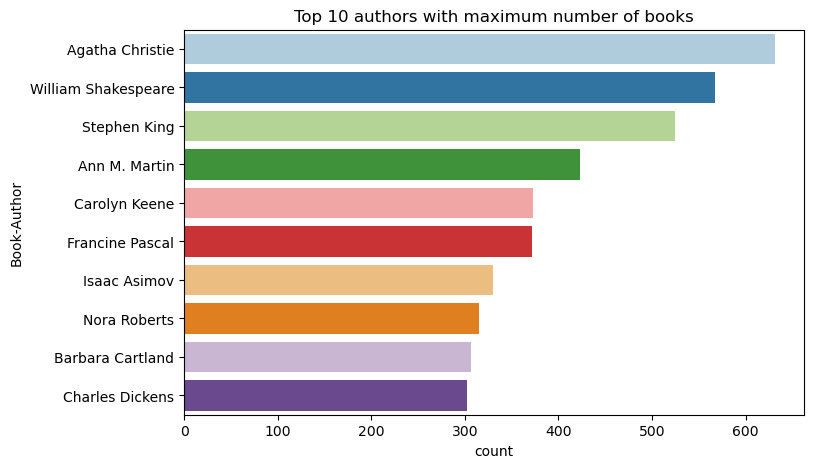

In [ ]:
df_books = df_items.toPandas() # Create a pandas dataframe from the spark dataframe for visualization
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Author",palette = 'Paired', data=df_books,order=df_books['Book-Author'].value_counts().index[0:10])
plt.title("Top 10 authors with maximum number of books")

Agatha Christie is the leading author with over 600 books, followed by William Shakespeare.

### Explore the User dataset
Take a look at the dataframe that stores the user data.

In [ ]:
display(df_users, summary=True)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3b55c788-a0d5-411f-b7d0-14677f8a281f)

Remove the rows with missing `User-ID` values to clean up the data prior to training.

In [ ]:
df_users = df_users.dropna(subset=(USER_ID_COL))
display(df_users, summary=True)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, 12253fc4-5663-4340-9209-99de39e32625)

Similarly, add the column named `_user_id` for later use which must only contain integers to suit your recommendation model. Therefore, use a `StringIndexer` to transform the `USER_ID_COL` into indices.

**Note**: In this scenario, the book dataset already consists of an integer column named `User-ID`. However, in order to make this notebook more robust, add a `_user_id` column for compatibility with different datasets.

In [ ]:
df_users = (
    StringIndexer(inputCol=USER_ID_COL, outputCol="_user_id")
    .setHandleInvalid("skip")
    .fit(df_users)
    .transform(df_users)
    .withColumn("_user_id", F.col("_user_id").cast("int"))
)

display(df_users.sort(F.col("_user_id").desc()))

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, ec85c5a8-7254-4061-9cc1-0770335cee97)

### Explore the Rating dataset
Take a look at the dataframe that stores the rating data.

In [ ]:
display(df_ratings, summary=True)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 16, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3f171886-f708-4d35-aea0-556e02b841dc)

Collect the distinct ratings and save them to a list named `ratings` for later use.

In [ ]:
ratings = [i[0] for i in df_ratings.select(RATING_COL).distinct().collect()]
print(ratings)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 17, Finished, Available)

[1, 6, 3, 5, 9, 4, 8, 7, 10, 2, 0]


##### Plot the top 10 books with the highest ratings

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 18, Finished, Available)

Text(0.5, 1.0, 'Top 10 books per number of ratings')

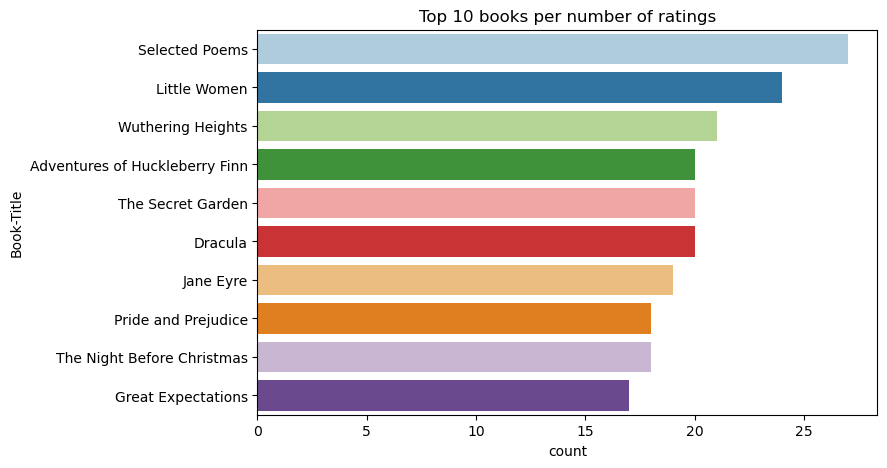

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Title",palette = 'Paired',data= df_books, order=df_books['Book-Title'].value_counts().index[0:10])
plt.title("Top 10 books per number of ratings")

"Selected Poems" is most favorable among users according to ratings. The books "Adventures of Huckleberry Finn", "The Secret Garden", and "Dracula", have the same rating.

### Merge all datasets

Once you've looked into all three dataframes corresponding to Book, User and Rating datasets, merge all three dataframes into one dataframe for a more comprehensive analysis.

In [ ]:
df_all = df_ratings.join(df_users, USER_ID_COL, "inner").join(
    df_items, ITEM_ID_COL, "inner"
)
df_all_columns = [
    c for c in df_all.columns if c not in ["_user_id", "_item_id", RATING_COL]
]

# Reorders the columns to ensure that _user_id, _item_id, and Book-Rating are the first three columns
df_all = (
    df_all.select(["_user_id", "_item_id", RATING_COL] + df_all_columns)
    .withColumn("id", F.monotonically_increasing_id())
    .cache()
)

display(df_all)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 017c9167-f3b2-4ee1-92db-476188a3c8f0)

Count and print the total number of distinct users, the total number of distinct books, and the total number of interactions.

In [ ]:
print(f"Total Users: {df_users.select('_user_id').distinct().count()}")
print(f"Total Items: {df_items.select('_item_id').distinct().count()}")
print(f"Total User-Item Interactions: {df_all.count()}")

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 20, Finished, Available)

Total Users: 278858
Total Items: 271360
Total User-Item Interactions: 1031136


### Create visualizations

Compute the most popular books and then display the top 10. Note that the `<topn>` popular items can be used for **"Popular"** or **"Most purchased"** recommendation section.

In [ ]:
# Compute top popular products
df_top_items = (
    df_all.groupby(["_item_id"])
    .count()
    .join(df_items, "_item_id", "inner")
    .sort(["count"], ascending=[0])
)

# Find top <topn> popular items
topn = 10
pd_top_items = df_top_items.limit(topn).toPandas()
pd_top_items.head(10)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 21, Finished, Available)

,_item_id,count,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,216737,2502,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,38729,1295,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,71056,883,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,7378,732,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,32497,723,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
5,87704,647,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
6,21423,615,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
7,145506,614,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...
8,133573,586,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...
9,94175,585,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...


StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 22, Finished, Available)

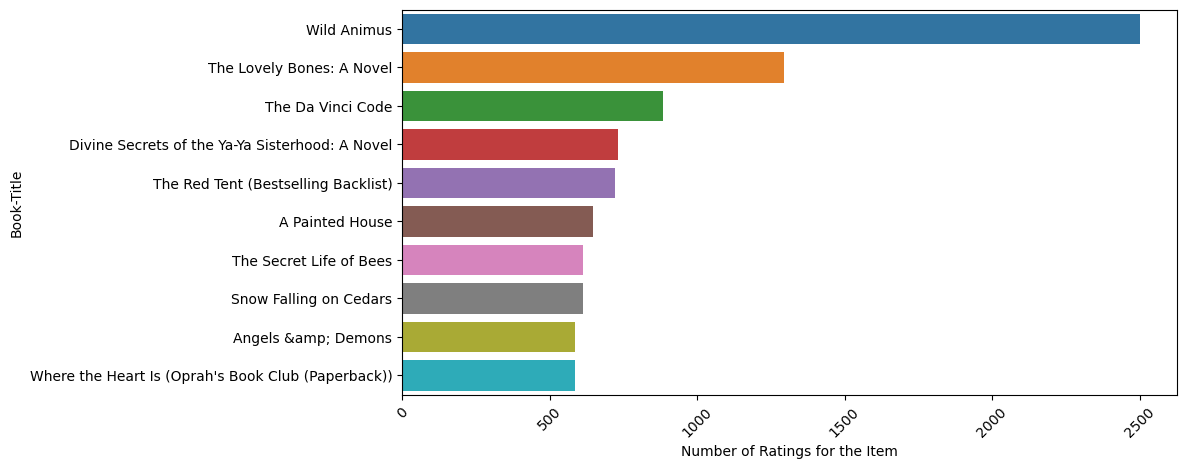

In [ ]:
# Plot top <topn> items
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation="vertical")
sns.barplot(y=ITEM_INFO_COL, x="count", data=pd_top_items)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("Number of Ratings for the Item")
plt.show()

This concludes the brief analysis of the three datasets where you added unique IDs to the user and item datasets and plotted the top items.

### Prepare data for machine learning training

#### Prepare training and test datasets

Prior to training, you need to perform some additional data preparation steps for the ALS recommender. First cast the rating column into the correct type and then sample the training data with user ratings. Once done with data preparation, split the data into training and test datasets.

In [ ]:
if IS_SAMPLE:
    # Must sort by '_user_id' before performing limit to ensure ALS work normally
    # Note that if train and test datasets have no common _user_id, ALS will fail
    df_all = df_all.sort("_user_id").limit(SAMPLE_ROWS)

# Cast column into the correct type
df_all = df_all.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))

# Using a fraction between 0 to 1 returns the approximate size of the dataset, i.e., 0.8 means 80% of the dataset
# Rating = 0 means the user didn't rate the item, so it can't be used for training
# Use the 80% if the dataset with rating > 0 as the training dataset
fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8
    fractions_test[i] = 1
# training dataset
train = df_all.sampleBy(RATING_COL, fractions=fractions_train)

# Join with leftanti will select all rows from df_all with rating > 0 and not in train dataset, i.e., the remaining 20% of the dataset
# test dataset
test = df_all.join(train, on="id", how="leftanti").sampleBy(
    RATING_COL, fractions=fractions_test
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 23, Finished, Available)

Also compute the sparsity of the dataset to gain a better understanding of the data and the problem at hand. Sparsity refers to the  situation in which feedback data is sparse and insufficient to identify similarities in users' interests.

In [ ]:
# Compute the sparsity of the dataset
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset - used as numerator
    count_nonzero = ratings.select(RATING_COL).count()
    print(f"Number of rows: {count_nonzero}")

    # Count the total number of distinct user_id and distinct product_id - used as denominator
    total_elements = (
        ratings.select("_user_id").distinct().count()
        * ratings.select("_item_id").distinct().count()
    )

    # Calculate the sparsity by dividing the numerator by the denominator
    sparsity = (1.0 - (count_nonzero * 1.0) / total_elements) * 100
    print("The ratings dataframe is ", "%.4f" % sparsity + "% sparse.")

get_mat_sparsity(df_all)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 24, Finished, Available)

Number of rows: 5000
The ratings dataframe is  99.7462% sparse.


In [ ]:
# Check the id range
# Note that ALS only supports values in the integer range
print(f"max user_id: {df_all.agg({'_user_id': 'max'}).collect()[0][0]}")
print(f"max item_id: {df_all.agg({'_item_id': 'max'}).collect()[0][0]}")

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 25, Finished, Available)

max user_id: 1347
max item_id: 271357


## Step 3: Develop and train the model

With your data in place, you can now define the model. Train an Alternating Least Squares (ALS) recommender to give users personalized recommendations.

### The machine learning model

With the train and test datasets defined, you can now get started on the recommendation model. Spark ML provides a convenient API for building an ALS model. However, the model default setting does not perform well at handling data sparsity and the cold start problem (the difficulty to make recommendations when the users or the items are new).
Combine cross validation and auto hyperparameter tuning to improve the performance of the model.

You need to import the required libraries for model training and evaluation.

In [ ]:
# Import Spark required libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 26, Finished, Available)

In [ ]:
# Specify the training parameters
num_epochs = 1  # Number of epochs, use 1 to reduce the training time
rank_size_list = [64]  # Values of rank in ALS for tuning
reg_param_list = [0.01, 0.1]  # Values of regParam in ALS for tuning
model_tuning_method = "TrainValidationSplit"  # TrainValidationSplit or CrossValidator

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 27, Finished, Available)

In [ ]:
# Build the recommendation model using ALS on the training data
# Set the cold start strategy to 'drop' to ensure that you don't get NaN evaluation metrics
als = ALS(
    maxIter=num_epochs,
    userCol="_user_id",
    itemCol="_item_id",
    ratingCol=RATING_COL,
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True,
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 28, Finished, Available)

### Tune model hyperparameters

In the following code, you construct a grid of parameters to search over the hyperparameters as well as a regression evaluator with root mean square error as the evaluation metric.

In [ ]:
#  Construct a grid search to select the best values for the training parameters
param_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, rank_size_list)
    .addGrid(als.regParam, reg_param_list)
    .build()
)

print("Number of models to be tested: ", len(param_grid))

# Define evaluator and set the loss fucntion to root mean squared error (RMSE) 
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol=RATING_COL, predictionCol="prediction"
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 29, Finished, Available)

Number of models to be tested:  2


Initiate different model tuning methods based on the pre-configured parameters. Further information of model tuning can be found at [Spark ML tuning](https://spark.apache.org/docs/latest/ml-tuning.html).

In [ ]:
# Build cross validation using CrossValidator and TrainValidationSplit
if model_tuning_method == "CrossValidator":
    tuner = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5,
        collectSubModels=True,
    )
elif model_tuning_method == "TrainValidationSplit":
    tuner = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        # 80% of the training data will be used for training, 20% for validation
        trainRatio=0.8,
        collectSubModels=True,
    )
else:
    raise ValueError(f"Unknown model_tuning_method: {model_tuning_method}")

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 30, Finished, Available)

### Evaluate the model

You now have different models to compare by evaluating them on the test data. If a model has been well trained, it should have high metrics on the datasets.

If the model is overfitted, you may need to increase the size of the training data or reduce some of the redundant features. You may also need to change the model's architecture or fine-tune its hyperparameters.

Note that if the R-Squared metric value is negative, it indicates that the trained model performs worse than a horizontal straight line, suggesting that the data is not explained by the trained model.

In [ ]:
def evaluate(model, data, verbose=0):
    """
    Evaluate the model by computing rmse, mae, r2 and variance over the data.
    """

    predictions = model.transform(data).withColumn(
        "prediction", F.col("prediction").cast("double")
    )

    if verbose > 1:
        # Show 10 predictions
        predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(
            10
        ).show()

    # Initialize the regression evaluator
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)
    rmse = _evaluator("rmse")
    mae = _evaluator("mae")
    r2 = _evaluator("r2")
    var = _evaluator("var")

    if verbose > 0:
        print(f"RMSE score = {rmse}")
        print(f"MAE score = {mae}")
        print(f"R2 score = {r2}")
        print(f"Explained variance = {var}")

    return predictions, (rmse, mae, r2, var)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 31, Finished, Available)

### Track the experiment with MLflow

Start the training and evaluation, then use MLflow to track all experiments and log parameters, metrics, and the models.

In [ ]:
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name="als"):
    # Train models
    models = tuner.fit(train)
    best_metrics = {"RMSE": 10e6, "MAE": 10e6, "R2": 0, "Explained variance": 0}
    best_index = 0
    # Evaluate models
    # Log model, metrics and parameters
    for idx, model in enumerate(models.subModels):
        with mlflow.start_run(nested=True, run_name=f"als_{idx}") as run:
            print("\nEvaluating on testing data:")
            print(f"subModel No. {idx + 1}")
            predictions, (rmse, mae, r2, var) = evaluate(model, test, verbose=1)

            signature = infer_signature(
                train.select(["_user_id", "_item_id"]),
                predictions.select(["_user_id", "_item_id", "prediction"]),
            )
            print("log model:")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-alsmodel",
                signature=signature,
                registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
                dfs_tmpdir="Files/spark",
            )
            print("log metrics:")
            current_metric = {
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained variance": var,
            }
            mlflow.log_metrics(current_metric)
            if rmse < best_metrics["RMSE"]:
                best_metrics = current_metric
                best_index = idx

            print("log parameters:")
            mlflow.log_params(
                {
                    "subModel_idx": idx,
                    "num_epochs": num_epochs,
                    "rank_size_list": rank_size_list,
                    "reg_param_list": reg_param_list,
                    "model_tuning_method": model_tuning_method,
                    "DATA_FOLDER": DATA_FOLDER,
                }
            )
    # Log best model and related metrics and parameters to the parent run
    mlflow.spark.log_model(
        models.subModels[best_index],
        f"{EXPERIMENT_NAME}-alsmodel",
        signature=signature,
        registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "subModel_idx": idx,
            "num_epochs": num_epochs,
            "rank_size_list": rank_size_list,
            "reg_param_list": reg_param_list,
            "model_tuning_method": model_tuning_method,
            "DATA_FOLDER": DATA_FOLDER,
        }
    )

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 32, Finished, Available)


Evaluating on testing data:
subModel No. 1
RMSE score = 0.8566210059249003
MAE score = 0.1821588006886569
R2 score = 0.7106032110200756
Explained variance = 3.6549009650456075
log model:
log metrics:
log parameters:

Evaluating on testing data:
subModel No. 2
RMSE score = 0.7864884691975794
MAE score = 0.19574565407764388
R2 score = 0.6559050461291518
Explained variance = 3.5250225745824895
log model:
log metrics:
log parameters:


/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer

To view the logged information for the training run, select the experiment named `aisample-recommendation` from your workspace. If you changed the experiment name, select the experiment with the name you specified. The logged information appears similar to the following images. Any experiment with its respective name is logged and you can track its parameters and performance metrics: 

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Book-Recommendation-Dataset/book-mlflow.png"  width="45%" height="10%">
<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Book-Recommendation-Dataset/book-logging.png"  width="45%" height="10%"> 


## Step 4: Load the final model for scoring and make predictions

### Offline recommendation
Once done with the training and having selected the best model, load the final model for scoring and generate predictions to recommend the top 10 books for each user. Also present the recommendations in an interpretable format.

In [ ]:
# Load the best model
# MLflow uses the PipelineModel to wrap the original model to extract the original ALSModel from the stages
model_uri = f"models:/{EXPERIMENT_NAME}-alsmodel/1"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark").stages[-1]

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 33, Finished, Available)

2023/09/11 14:41:30 INFO mlflow.spark: 'models:/aisample-recommendation-alsmodel/1' resolved as 'abfss://33953aa3-b8e7-44f4-a8aa-0c2588e6ce74@onelakemsit.pbidedicated.windows.net/fc42012a-38f8-4b16-8396-35751718fbac/3a8e0332-bc1a-4fbd-9630-e48474d81f29/artifacts'
2023/09/11 14:41:31 INFO mlflow.spark: File 'abfss://33953aa3-b8e7-44f4-a8aa-0c2588e6ce74@onelakemsit.pbidedicated.windows.net/fc42012a-38f8-4b16-8396-35751718fbac/3a8e0332-bc1a-4fbd-9630-e48474d81f29/artifacts/sparkml' is already on DFS, copy is not necessary.


In [ ]:
# Generate top 10 book recommendations for each user
userRecs = loaded_model.recommendForAllUsers(10)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 34, Finished, Available)

In [ ]:
# Represent the recommendations in an interpretable format
userRecs = (
    userRecs.withColumn("rec_exp", F.explode("recommendations"))
    .select("_user_id", F.col("rec_exp._item_id"), F.col("rec_exp.rating"))
    .join(df_items.select(["_item_id", "Book-Title"]), on="_item_id")
)
userRecs.limit(10).show()

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 35, Finished, Available)

+--------+--------+---------+--------------------+
|_item_id|_user_id|   rating|          Book-Title|
+--------+--------+---------+--------------------+
|   71056|       7|10.227177|   The Da Vinci Code|
|  170437|       7|8.2797165|The Five People Y...|
|   44865|       7|7.9993467|Lasher: Lives of ...|
|  125415|       7|6.9831495|Harry Potter and ...|
|   86727|       7| 6.354976|     No Greater Love|
|    7481|       7|6.0774207|The Poisonwood Bi...|
|  169605|       7| 6.069703|     Blood and Money|
|  236327|       7|6.0508156|  Concept of Justice|
|   70557|       7|5.9909506|Tuesdays with Mor...|
|   86654|       7|5.8801236|      A Time to Kill|
+--------+--------+---------+--------------------+



You have received the top 10 book recommendations for each user.

#### Save the predictions to the lakehouse

Finally, write the recommendation generated by the best ALS model back to the lakehouse.

In [ ]:
# Code to save the userRecs into lakehouse
userRecs.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/userRecs"
)

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 36, Finished, Available)

In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, db09740a-036f-4e14-9afc-ee8d112e8535, 37, Finished, Available)

Full run cost 522 seconds.
